# Notebook to serve as example of how to use polaraveraging
################################################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling
import clmm 

In [2]:
# needed for now to import mock_data
import sys
sys.path.append('./support')
import mock_data as mock

### Define cosmology object

In [3]:
#if pyccl is installed, use it, else, use astropy FlatLambdaDCM object
#try:
#    import pyccl as ccl
#    cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b = 0.05,h = 0.7,n_s = 0.97, sigma8 = 0.8, Omega_k = 0.)
#except:
#    from astropy.cosmology import FlatLambdaCDM
#    cosmo = FlatLambdaCDM(H0=70., Om0=0.3, Ob0=0.025)
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3, Ob0=0.025)

## 1) Generate cluster object with mock data

#### Preparing config for mock data generation

Mock data will include shape noise, galaxies from redshift distribution and a pdz for each galaxies

In [4]:
config={}
config['cluster_id'] = 'mock cluster'
config['cluster_m'] = 1.e15
config['cluster_z'] = 0.3
config['src_z'] = 0.8
config['concentration'] = 4
config['ngals'] = 1000
config['Delta'] = 200
config['cosmo'] = cosmo

noisy_data_z = mock.MockData(config=config)
noisy_data_z.generate(is_shapenoise=True, is_zdistribution=True, is_zerr=True)

#### Loading this into a CLMM cluster object

In [5]:
# At the moment mock data only allow for a cluster centred on (0,0)
cluster_ra = 0.0
cluster_dec = 0.0
gc_object = gc.GalaxyCluster(config['cluster_id'], cluster_ra, cluster_dec, 
                             config['cluster_z'], noisy_data_z.catalog)
#gc_object.save("GC_from_mock_data.pkl")

## 2) Load cluster object

In [6]:
#the cluster object contains properties of the lens: ra_l, dec_l, z_l and that of the sources : ra_s, dec_s, e1, e1 
#cl = gc.load_cluster("GC_from_mock_data.pkl")
cl = gc_object
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra, "; dec:", cl.dec, "; z_l :", cl.z)
print ("The number of source galaxies is :", len(cl.galcat))

Cluster info = ID: mock cluster ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 1000


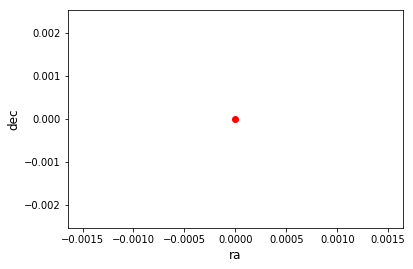

In [7]:
#plot cluster and galaxy positions
cl.galcat['ra'] = cl.galcat['ra']
cl.galcat['dec'] = cl.galcat['dec']

plt.scatter(cl.galcat['ra'],cl.galcat['dec'] ,color = 'blue',s= 1, alpha=0.3)
plt.plot(cl.ra,cl.dec, 'ro')
plt.ylabel('dec', fontsize = "large")
plt.xlabel('ra',fontsize = "large");

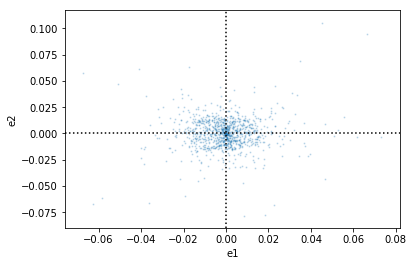

In [8]:
#check the ellipticities
fig, ax1 = plt.subplots(1,1)

ax1.scatter(cl.galcat['e1'],cl.galcat['e2'], s = 1, alpha = 0.2)
ax1.set_xlabel('e1')
ax1.set_ylabel('e2');
ax1.axvline(0, linestyle = 'dotted', color ='black')
ax1.axhline(0, linestyle = 'dotted', color ='black')

## 3) Compute and plot shear profiles

#### Compute angular separation, cross and tangential shear for each galaxies

In [9]:
# calculate angular separation and tangential shear and cross shear for each source galaxy
theta, g_t , g_x = pa.compute_shear(cl, geometry = "flat")

#### Plot shear distributions for verification

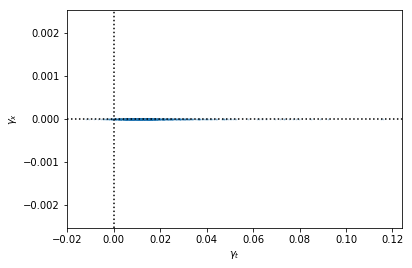

In [10]:
#check the shear, now the shear can be accessed through the cluster object
fig, ax1 = plt.subplots(1,1)

ax1.scatter(cl.galcat['gt'],cl.galcat['gx'], s = 1, alpha = 0.2) 
ax1.set_xlabel('$\\gamma_t$')
ax1.set_ylabel('$\\gamma_x$');
ax1.axvline(0, linestyle = 'dotted', color ='black')
ax1.axhline(0, linestyle = 'dotted', color ='black')

#### Compute transversal and cross shear profiles in units defined by user, using defaults binning 

In [11]:
pa.make_shear_profile?

Signature:
pa.make_shear_profile(
    ['cluster', 'angsep_units', 'bin_units', 'bins=10', 'cosmo=None', 'add_to_cluster=True'],
)
Docstring:
Compute the shear profile of the cluster

We assume that the cluster object contains information on the cross and
tangential shears and angular separation of the source galaxies

This function can be called in two ways using an instance of GalaxyCluster

1. Pass an instance of GalaxyCluster into the function::

    make_shear_profile(cluster, 'radians', 'radians')

2. Call it as a method of a GalaxyCluster instance::

    cluster.make_shear_profile('radians', 'radians')

Parameters
----------
cluster : GalaxyCluster
    Instance of GalaxyCluster that contains the cross and tangential shears of
    each source galaxy in its `galcat`
angsep_units : str
    Units of the calculated separation of the source galaxies
    Allowed Options = ["radians"]
bin_units : str
    Units to use for the radial bins of the shear profile
    Allowed Options = ["radian

In [13]:
profiles = pa.make_shear_profile(cl, "radians", "kpc", cosmo = cosmo) 

/pbs/throng/lsst/software/desc/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


#### Use function to plot the profiles

In [14]:
fig, ax = pa.plot_profiles(cl);

AttributeError: 'GalaxyCluster' object has no attribute 'profile_radius_unit'

#### Compute transversal and cross shear profiles in units defined by user, using a new binning

In [16]:
#BE CAREFULL BECAUSE THIS OVERWRITE THE CLUSTER OBJECT (better implementation will be done latter)

#define bins
new_bins = pa.make_bins(1, 4,20) 

#compute transversal and cross shear profiles in units defined by user, using binning defined by user
new_profiles = pa.make_shear_profile(cl, "radians","Mpc", bins=new_bins, cosmo = cosmo)

#plot new profiles
fig1, ax1 = pa.plot_profiles(cl,"Mpc")

/pbs/throng/lsst/users/mricci/desc/CLMM/clmm/polaraveraging.py:285: RuntimeWarning: invalid value encountered in true_divide
  gt_err = gt_std / gt_counts
/pbs/throng/lsst/users/mricci/desc/CLMM/clmm/polaraveraging.py:286: RuntimeWarning: invalid value encountered in true_divide
  gx_err = gx_std / gx_counts


AttributeError: 'GalaxyCluster' object has no attribute 'profile_radius_unit'

#### You can also access the profiles quantities and play with them

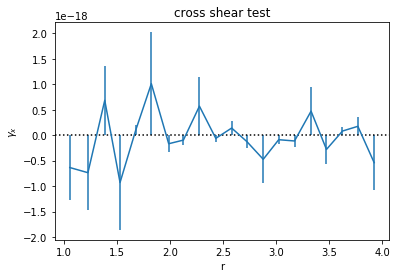

In [17]:
plt.title('cross shear test')
plt.errorbar(new_profiles['radius'],new_profiles['gx'],new_profiles['gx_err'])
plt.title('cross shear test')
plt.axhline(0, linestyle = 'dotted', color = 'black')
plt.xlabel("r")
plt.ylabel('$\\gamma_x$');